In [2]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

np.random.seed(42)
torch.manual_seed(42)

In [68]:
transforms = v2.Compose([
    v2.ToTensor(),
])

train_complete_set = torchvision.datasets.MNIST('./datasets', train=True, transform=transforms, download=True)
train_set, val_set = random_split(train_complete_set, [0.95, 0.05], torch.Generator().manual_seed(42))

test_set = torchvision.datasets.MNIST('./datasets', train=False, transform=transforms, download=True)

/home/mk/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [69]:
batch_size = 256

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [107]:
class Solver:
    def __init__(self, model, lr=3e-3, reg=0.0, optim=torch.optim.Adam, batch_size=batch_size, criterion=nn.CrossEntropyLoss, print_every=100, anneal=False):
        self.lr = lr
        self.reg = reg
        self.model = model
        self.batch_size = batch_size
        self.optim = optim(model.parameters(), lr=lr, weight_decay=reg)
        self.criterion = criterion()
        self.dataloaders = {}
        self.loss_history = []
        self.print_every = print_every

        self.anneal = anneal
        self.anneal_counter = 0
        self.last_anneal_idx = 0
        self.max_anneal_count = 3

    def set_data_loader(self, loader, split):
        self.dataloaders[split] = loader

    def estimate_loss(self, split):
        dataloader = self.dataloaders[split]

        if dataloader == None:
            return -1.0

        self.model.eval()
        avg_loss = 0.0
        avg_kl_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                if i % 5000 == 0 and i > 0:
                    break
                images, _ = data
                N = images.shape[0]
                images = images.to(device).reshape(N, -1)

                out, mean, log_var  = self.model(images)
                kl_loss = ((mean**2 + log_var.exp() - 1 - log_var) / 2).mean()
                avg_kl_loss += kl_loss.item()

                loss = self.criterion(out, images)
                avg_loss += loss.item()

        self.model.train()
        print(f"KL LOSS: {avg_kl_loss  / len(dataloader)} RECON LOSS: {avg_loss / len(dataloader)}")
        return avg_loss / len(dataloader)
    
    def anneal_learning_rate(self):
        num_losses = len(self.loss_history)
        if (self.anneal_counter == self.max_anneal_count
            or num_losses < 3
            or num_losses - self.last_anneal_idx < 3):
            return

        train = [l[0] for l in self.loss_history]
        arr = np.array(train[-3:])
        if arr.std() >= 1e-4:
            return

        self.last_anneal_idx = num_losses
        self.anneal_counter += 1
        print(f"Annealing learning_rate {self.lr} by 10. New learning rate {self.lr / 10}. Anneal count {self.anneal_counter} / {self.max_anneal_count}.")
        self.lr /= 10

    def train(self, loader, epochs=1):
        for e in range(epochs):
            for i, data in enumerate(loader):
                if i % self.print_every == 0 and i > 0:
                    train_loss = self.estimate_loss('train')
                    val_loss = self.estimate_loss('val')
                    
                    print(f"epoch: {e} iter: {i} train_loss: {train_loss} val_loss: {val_loss}")

                    self.loss_history.append((train_loss, val_loss))
                    if self.anneal:
                        self.anneal_learning_rate()

                images, _ = data
                N = images.shape[0]
                images = images.to(device).reshape(N, -1)

                self.optim.zero_grad()

                out, mean, log_var  = self.model(images)
                kl_loss = ((mean**2 + log_var.exp() - 1 - log_var) / 2).sum(-1)
                loss = (nn.functional.mse_loss(out, images, reduction="none").sum(-1) + kl_loss).mean(0)
                loss.backward()
                self.optim.step()


In [108]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.encoder = nn.Sequential(
            nn.Linear(in_channels, 512, device=device),
            self.leaky_relu,
            nn.Linear(512, 256, device=device),
            self.leaky_relu,
            nn.Linear(256, out_channels, device=device),
            self.leaky_relu,
        )

        self.decoder = nn.Sequential(
            nn.Linear(out_channels, 256, device=device),
            self.leaky_relu,
            nn.Linear(256, 512, device=device),
            self.leaky_relu,
            nn.Linear(512, in_channels, device=device),
            nn.Sigmoid(),
        )
        self.ln_mean = nn.Sequential(nn.Linear(out_channels, out_channels, device=device), nn.LayerNorm(out_channels), nn.Sigmoid())
        self.ln_var  = nn.Sequential(nn.Linear(out_channels, out_channels, device=device), nn.LayerNorm(out_channels), nn.Sigmoid())


    def forward(self, input):
        mean, log_var = self.encode(input)
        q = self.reparameterize(mean, log_var)
        x = self.decode(q)
        return [x, mean, log_var]
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps  = torch.randn_like(std, requires_grad=False)

        return mean + (std * eps)

    def encode(self, x):
        encoded = self.encoder(x)
        mean = self.ln_mean(encoded)
        log_var  = self.ln_var(encoded)
        
        return [mean, log_var]

    def decode(self, embd):
        return self.decoder(embd)

In [109]:
model = Net(784, 100)
solver = Solver(model, lr=0.005, batch_size=batch_size, criterion=nn.BCELoss)
solver.set_data_loader(train_loader, 'train')
solver.set_data_loader(val_loader, 'val')

In [126]:
solver.lr = 0.0001
solver.train(train_loader, 50)

KL LOSS: 0.06382277429170673 RECON LOSS: 0.20502110092896517
KL LOSS: 0.06414334910611312 RECON LOSS: 0.20389631887276968
epoch: 0 iter: 100 train_loss: 0.20502110092896517 val_loss: 0.20389631887276968
KL LOSS: 0.06226313246138427 RECON LOSS: 0.20530081570415754
KL LOSS: 0.06244558685769638 RECON LOSS: 0.20493896181384721
epoch: 0 iter: 200 train_loss: 0.20530081570415754 val_loss: 0.20493896181384721
KL LOSS: 0.06263748347558783 RECON LOSS: 0.2047472267407473
KL LOSS: 0.06294521192709605 RECON LOSS: 0.20380564406514168
epoch: 1 iter: 100 train_loss: 0.2047472267407473 val_loss: 0.20380564406514168
KL LOSS: 0.06423520921591686 RECON LOSS: 0.20496585276896642
KL LOSS: 0.06439332043131192 RECON LOSS: 0.20433525368571281
epoch: 1 iter: 200 train_loss: 0.20496585276896642 val_loss: 0.20433525368571281
KL LOSS: 0.0632246631143339 RECON LOSS: 0.20451650411024222
KL LOSS: 0.06333191941181819 RECON LOSS: 0.20379790291190147
epoch: 2 iter: 100 train_loss: 0.20451650411024222 val_loss: 0.203797

KeyboardInterrupt: 

In [111]:
print(model(recon_img)[2])

tensor([[0.0406, 0.0091, 0.0129, 0.0158, 0.0074, 0.0116, 0.0103, 0.0059, 0.0053,
         0.0090, 0.0059, 0.0124, 0.0128, 0.0131, 0.0096, 0.0158, 0.0111, 0.0090,
         0.0116, 0.0101, 0.0406, 0.0137, 0.0130, 0.0213, 0.0074, 0.0096, 0.0085,
         0.0135, 0.0113, 0.0084, 0.0128, 0.0061, 0.0099, 0.0082, 0.0083, 0.0146,
         0.0160, 0.0436, 0.0070, 0.0419, 0.0058, 0.0447, 0.0086, 0.0114, 0.0131,
         0.0089, 0.0012, 0.0127, 0.0116, 0.0040, 0.0084, 0.0070, 0.0028, 0.0140,
         0.0062, 0.0101, 0.0157, 0.0197, 0.0127, 0.0123, 0.0084, 0.0126, 0.0106,
         0.0185, 0.0076, 0.0068, 0.0147, 0.0123, 0.0080, 0.0022, 0.0044, 0.0101,
         0.0049, 0.0105, 0.0053, 0.0108, 0.0078, 0.0082, 0.0100, 0.0103, 0.0100,
         0.0063, 0.0380, 0.0085, 0.0152, 0.0088, 0.0138, 0.0105, 0.0074, 0.0059,
         0.0072, 0.0146, 0.0142, 0.0166, 0.0061, 0.0033, 0.0576, 0.0085, 0.0059,
         0.0095]], grad_fn=<SigmoidBackward0>)


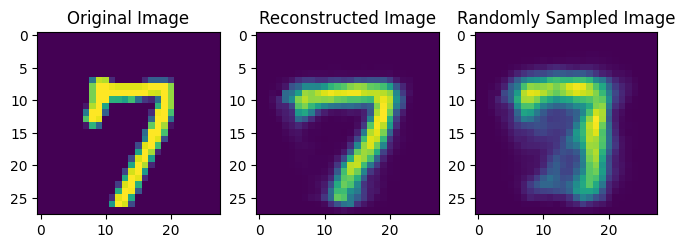

In [124]:
columns = 3
rows = 1
w = 10
h = 2
fig = plt.figure(figsize=(8, 8))

fig.add_subplot(rows, columns, 1)
img = train_set[83][0]
plt.title("Original Image")
plt.imshow(img.reshape(28, 28).cpu().detach().numpy())

fig.add_subplot(rows, columns, 2)
recon_img = img.to(device).reshape(1, 784)
x, _, _ = model(recon_img)
plt.title("Reconstructed Image")
plt.imshow(x.reshape(28, 28).cpu().detach().numpy())

fig.add_subplot(rows, columns, 3)
rand_img = torch.randn_like(img).to(device).reshape(1, 784)
x, _, _ = model(rand_img)
plt.title("Randomly Sampled Image")
plt.imshow(x.reshape(28, 28).cpu().detach().numpy())

plt.show()

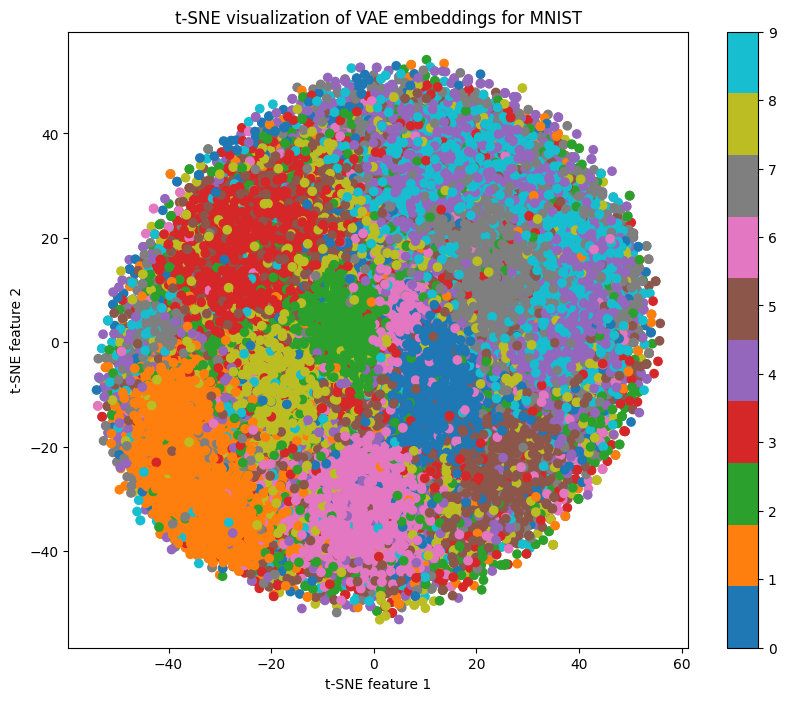

In [81]:
from sklearn.manifold import TSNE

bs = 100

# Load MNIST dataset
train_tsne_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=False)

embeddings = []
labels = []

vae = model
vae.eval()
with torch.no_grad():
    for batch_images, batch_labels in train_tsne_loader:

        # Encode images to get embeddings
        # Adjust this line according to your VAE model's encoder structure
        # print(batch_labels.shape)
        mean, log_var = vae.encode(batch_images.reshape(bs, -1))
        q = vae.reparameterize(mean, log_var)
        batch_embeddings = q.cpu().numpy()
        
        embeddings.append(batch_embeddings)
        labels.append(batch_labels.numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter)
plt.title('t-SNE visualization of VAE embeddings for MNIST')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()